# FigS13
Analysis of Ecdysone Receptor nuclear concentration

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from glob import glob
from scipy.stats import zscore
from matplotlib import rc
import matplotlib as mpl
from diptericin_paper_utils import colors, dpt, standard_ap, fb_start_id, bootstrap_wass1_from_means, emd_from_line_dist
import pickle

/home/brandon/anaconda3/envs/ome_zarr/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
#%matplotlib qt
%matplotlib inline

In [5]:
rc('axes', linewidth=4)
linewidth=4
fontsize=24
mpl.rc('axes', linewidth=linewidth)
mpl.rc('font', family='Arial')

individual_colors = ((27,158,119),
          (217,95,2),
          (117,112,179),
          (231,41,138),
          (102,166,30),
          (230,171,2))

def style_axes(ax, fontsize=24):
    plt.minorticks_off()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    plt.tight_layout()
    
    return ax

In [6]:
def bin_aps(df, bins, ap_col='y'):
    _counts, bins = np.histogram(df.get(ap_col), bins)
    #bins = bins[1:]
    bins = bins[:-1]
    partial_func = partial(get_ap_bin, bins=bins)
    binned_aps = df.get(ap_col).apply(partial_func)
    df[f'binned_{ap_col}'] = binned_aps.values
    
    return df
    

def get_ap_bin(this_ap, bins):
    this_bin = np.where(np.abs(this_ap - bins) == np.nanmin(np.abs(this_ap - bins)))[0][0]

    return this_bin
    


In [7]:
"""insert path to the folder of all data files here"""
path_to_supplemental_data_files = r'/home/brandon/Documents/Code/diptericin-paper/SupplementalDataFiles_revision'

<AxesSubplot:xlabel='fraction of anterior-posterior axis', ylabel='mean EcR-B1 \nfluorescence intensity (a.u.)'>

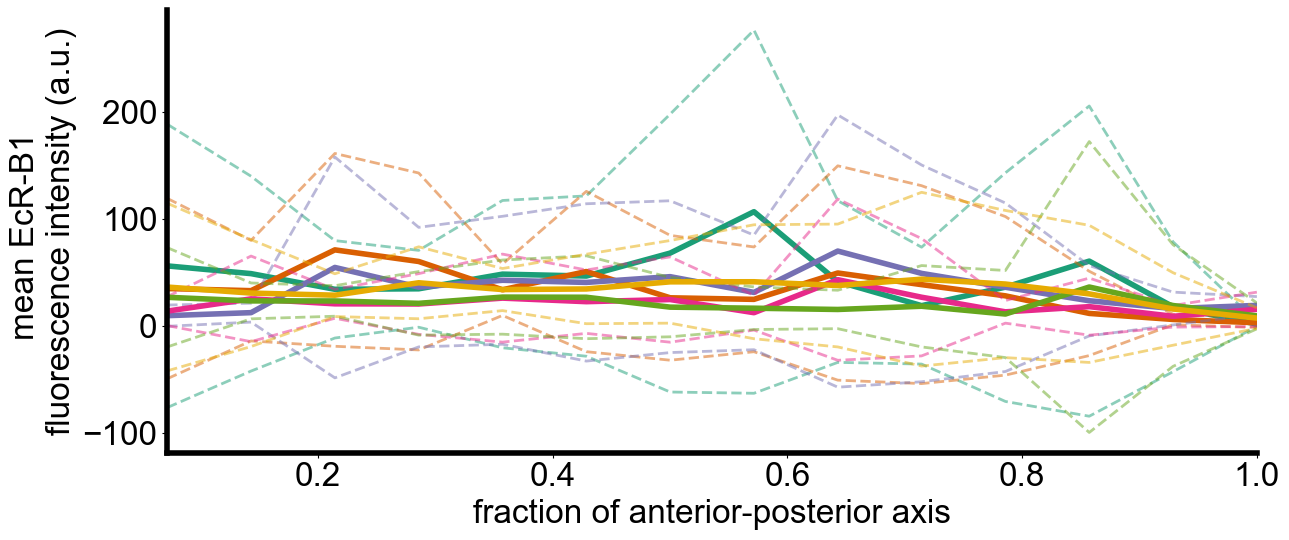

In [9]:
n_bins = len(standard_ap[fb_start_id:]) - 1
all_means = np.zeros((6, n_bins))
all_stds = np.zeros((6, n_bins))
bins = standard_ap[fb_start_id:]
ap_col = 'ap'
quant_col = 'ch0'
method = 'bkg_sub_mean_ch0'
counter= 0
q95 = np.zeros(6)
files = glob(path_to_supplemental_data_files + '/FigS13/*.pkl')
plt.figure(figsize=(13, 5.5))
for file in files:
    df = pd.read_pickle(file)


    df['ap'] = df.y / df.y.max()
    df = bin_aps(df, bins, ap_col='ap')

    binned_means = df.get([method, f'binned_{ap_col}']).groupby(by=f'binned_{ap_col}').mean().values.flatten()
    #binned_means = df.get([method, f'binned_{ap_col}']).groupby(by=f'binned_{ap_col}').sum().values.flatten()

    binned_std = df.get([method, f'binned_{ap_col}']).groupby(by=f'binned_{ap_col}').std().values.flatten()

    m = binned_means
    s = binned_std
    l = m -s
    u = m + s
    ap = standard_ap[fb_start_id:-1]
    #ap = bins[:-1] / np.max(bins[:-1])
    plt.plot(ap, m, color=np.array(individual_colors[counter]) / 255, linewidth=4)
    plt.plot(ap, l, '--', color=np.array(individual_colors[counter]) / 255, linewidth=2, alpha=0.5)
    plt.plot(ap, u, '--', color=np.array(individual_colors[counter]) / 255, linewidth=2, alpha=0.5)

    all_means[counter] = binned_means
    all_stds[counter] = binned_std
    q95[counter] = np.quantile(df.get(method), 0.95)

    counter += 1
        
plt.xlabel('fraction of anterior-posterior axis', fontsize=fontsize)
plt.ylabel('mean EcR-B1 \nfluorescence intensity (a.u.)', fontsize=fontsize)
plt.xlim([bins[0], 1])
style_axes(plt.gca())






In [26]:
#plt.savefig(r'/home/brandon/Documents/Code/diptericin-paper/figures/Fig3-Ecr/ecr_ap_dist_individuals.pdf')

<AxesSubplot:xlabel='fraction of anterior-posterior axis', ylabel='mean mNeonGreen-EcR-B1 \nfluorescence intensity (a.u.)'>

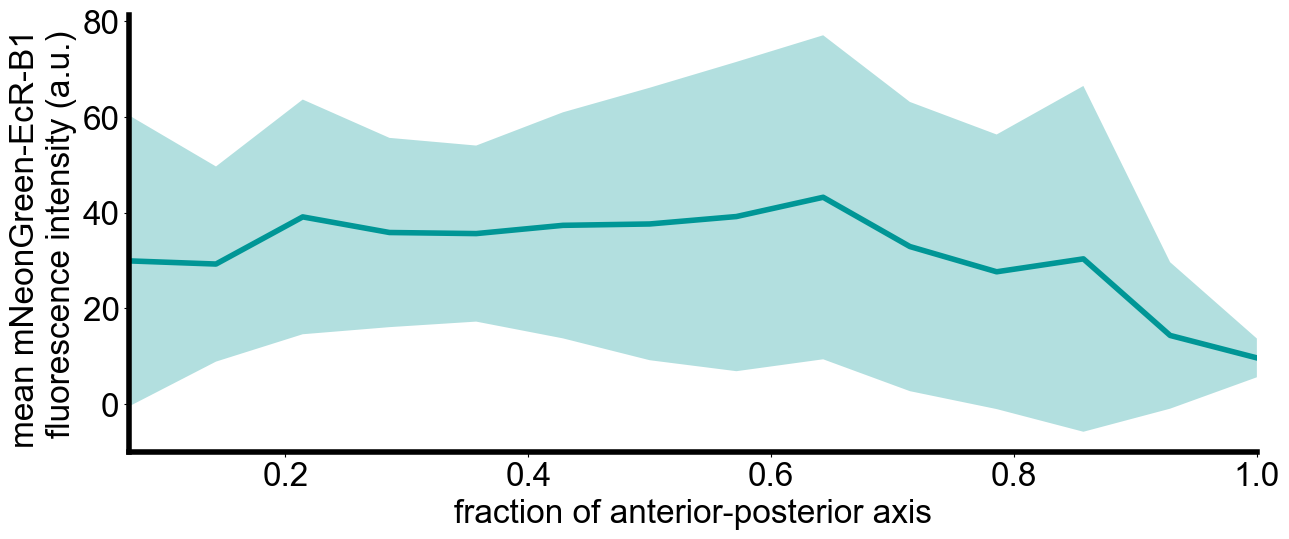

In [10]:
color=(0, 150 / 255, 150 / 255)

plt.figure(figsize=(13, 5.5))

m = np.mean(all_means, axis=0)

# uncertainty is dominated by individual uncertainties
s = np.sqrt(np.mean(all_stds ** 2, axis=0) / len(all_stds))

l = m -s
u = m + s
plt.plot(standard_ap[fb_start_id:-1], m, color=color, linewidth=4, label='mean')
plt.fill_between(standard_ap[fb_start_id:-1], l, u, facecolor=color, alpha=0.3, label='_nolabel_')
plt.xlabel('fraction of anterior-posterior axis', fontsize=fontsize)
plt.ylabel('mean mNeonGreen-EcR-B1 \nfluorescence intensity (a.u.)', fontsize=fontsize)
plt.xlim([standard_ap[fb_start_id], 1])
style_axes(plt.gca())




In [22]:
#plt.savefig(r'/home/brandon/Documents/Code/diptericin-paper/figures/Fig3-Ecr/ecr_ap_dist_shaded_errorbar_v2.pdf')